# Construction materials price forecasting

2020-03-31

Leslie Emery

# Summary

## Challenge
The challenge is to forecast prices for core construction materials up to 6 months in the future. The manager of the construction company wants to be able to anticipate upcoming increases in material unit prices.

## Approach
- Plot the data to view annual, monthly, weekly, and daily patterns
- Decompose time series to identify trends and cyclic/seasonal patterns
- Fit an ARIMA model to predict prices for last 20% of data

## Takeaways
- All five construction material prices can be forecast well using an ARIMA model
- Based on forecast prices, very large increases in price can be escaped by buying during predicted lows, including before the following major increases:
    - Steel increases in late 2016 and late 2017
    - Rebar increases in early 2018 and late 2016
    - Multiple concrete increases from 2016 - 2018
    - Plywood increase in 2017
- Glass prices don't spike as much and are more steady so this approach will have less benefit for glass costs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import statsmodels.api as sm

from IPython.display import display

pio.templates.default = "plotly_white"
sns.set(style="whitegrid", font_scale=1.25)
plt.figure(figsize=(12.8, 9.6), dpi=400)

<Figure size 5120x3840 with 0 Axes>

<Figure size 5120x3840 with 0 Axes>

In [2]:
data_dir = '~/devel/insight-data-challenges/06-clairvoyant-constructor/data'
output_dir = '~/devel/insight-data-challenges/06-clairvoyant-constructor/output'

## Read in and clean the data

In [3]:
df = pd.read_csv(
    os.path.join(os.path.expanduser(data_dir), 'construction_material_prices_2008_2018.csv'),
    parse_dates=['Unnamed: 0']
)

display(df.info())

with pd.option_context('display.max_columns', 100):
    print(df.head(15))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945 entries, 0 to 2944
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unnamed: 0      2945 non-null   datetime64[ns]
 1   price_steel     2309 non-null   float64       
 2   price_rebar     1649 non-null   float64       
 3   price_glass     1472 non-null   float64       
 4   price_concrete  1447 non-null   float64       
 5   price_plywood   2673 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 138.2 KB


None

   Unnamed: 0  price_steel  price_rebar  price_glass  price_concrete  \
0  2007-01-01          NaN          NaN          NaN             NaN   
1  2007-01-03          NaN          NaN          NaN             NaN   
2  2007-01-04          NaN          NaN          NaN             NaN   
3  2007-01-05          NaN          NaN          NaN             NaN   
4  2007-01-08          NaN          NaN          NaN             NaN   
5  2007-01-09          NaN          NaN          NaN             NaN   
6  2007-01-10          NaN          NaN          NaN             NaN   
7  2007-01-11          NaN          NaN          NaN             NaN   
8  2007-01-12          NaN          NaN          NaN             NaN   
9  2007-01-16          NaN          NaN          NaN             NaN   
10 2007-01-17          NaN          NaN          NaN             NaN   
11 2007-01-18          NaN          NaN          NaN             NaN   
12 2007-01-19          NaN          NaN          NaN            

### Name the date column

In [4]:
df = df.rename(columns={'Unnamed: 0': 'Date'})
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945 entries, 0 to 2944
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            2945 non-null   datetime64[ns]
 1   price_steel     2309 non-null   float64       
 2   price_rebar     1649 non-null   float64       
 3   price_glass     1472 non-null   float64       
 4   price_concrete  1447 non-null   float64       
 5   price_plywood   2673 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 138.2 KB


None

### Check data values

The range of each price looks reasonable

In [5]:
display(df.describe())

price_steel  price_rebar  price_glass  price_concrete  price_plywood
count  2309.000000  1649.000000  1472.000000     1447.000000    2673.000000
mean     12.611319    18.306339    29.997962       26.000636      12.775067
std       6.038862     8.587938     6.524622        7.314764       3.931698
min       3.062500     3.000000    16.000000       10.416667       5.000000
25%       8.500000    12.071429    25.000000       20.559028      10.125000
50%      10.500000    16.500000    29.000000       25.043478      12.125000
75%      14.833333    22.500000    35.000000       30.000000      14.333333
max      41.000000    55.000000    48.000000       50.000000      34.000000

Range of dates also looks reasonable

In [6]:
display(df['Date'].min(), df['Date'].max())

Timestamp('2007-01-01 00:00:00')

Timestamp('2018-06-19 00:00:00')

### Reshape the data for plotting

In [7]:
# df2 = pd.wide_to_long(df, stubnames='price', i='Date', j='material')
price_cols = df.columns[df.columns.str.startswith('price_')]
df_longer = df.melt(var_name='Material', value_name='Price', id_vars=['Date'], value_vars=price_cols)
df_longer['Material'] = df_longer['Material'].str.replace('price_', '')
display(df_longer)

Date Material  Price
0     2007-01-01    steel    NaN
1     2007-01-03    steel    NaN
2     2007-01-04    steel    NaN
3     2007-01-05    steel    NaN
4     2007-01-08    steel    NaN
...          ...      ...    ...
14720 2018-06-13  plywood    NaN
14721 2018-06-14  plywood    NaN
14722 2018-06-15  plywood    NaN
14723 2018-06-18  plywood    NaN
14724 2018-06-19  plywood    NaN

[14725 rows x 3 columns]

### Remove initial NaN rows

Many of the rows in the data are NaN, but I need to keep them because I want to be able to set the period of the pandas time series index. So here I'm just going to remove the all NaN rows from the beginoing of the series.

In [8]:
old_shape = df.shape
first_valid_idx = df[price_cols].isna().any(axis=1).idxmin()
df = df.loc[first_valid_idx:]
print('{} rows were removed'.format(old_shape[0] - df.shape[0]))

359 rows were removed


## Add variables for date components

I'm going to use these variables for plotting.

In [9]:
df['year'] = df['Date'].dt.year.astype('category')
df['month'] = df['Date'].dt.month.astype('category')
df['day'] = df['Date'].dt.day
df['dayofyear'] = df['Date'].dt.dayofyear
df['dayofweek'] = df['Date'].dt.dayofweek.astype('category')
df['isweekday'] = df['dayofweek'].isin(range(5))
df['week'] = df['Date'].dt.week.astype('category')
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2586 entries, 359 to 2944
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            2586 non-null   datetime64[ns]
 1   price_steel     2191 non-null   float64       
 2   price_rebar     1581 non-null   float64       
 3   price_glass     1341 non-null   float64       
 4   price_concrete  1326 non-null   float64       
 5   price_plywood   2435 non-null   float64       
 6   year            2586 non-null   category      
 7   month           2586 non-null   category      
 8   day             2586 non-null   int64         
 9   dayofyear       2586 non-null   int64         
 10  dayofweek       2586 non-null   category      
 11  isweekday       2586 non-null   bool          
 12  week            2586 non-null   category      
dtypes: bool(1), category(4), datetime64[ns](1), float64(5), int64(2)
memory usage: 178.5 KB


None

In [10]:
df_longer['year'] = df_longer['Date'].dt.year.astype('category')
df_longer['month'] = df_longer['Date'].dt.month.astype('category')
df_longer['day'] = df_longer['Date'].dt.day
df_longer['dayofyear'] = df_longer['Date'].dt.dayofyear
df_longer['dayofweek'] = df_longer['Date'].dt.dayofweek.astype('category')
df_longer['isweekday'] = df_longer['dayofweek'].isin(range(5))
df_longer['week'] = df_longer['Date'].dt.week.astype('category')
display(df_longer.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14725 entries, 0 to 14724
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       14725 non-null  datetime64[ns]
 1   Material   14725 non-null  object        
 2   Price      9550 non-null   float64       
 3   year       14725 non-null  category      
 4   month      14725 non-null  category      
 5   day        14725 non-null  int64         
 6   dayofyear  14725 non-null  int64         
 7   dayofweek  14725 non-null  category      
 8   isweekday  14725 non-null  bool          
 9   week       14725 non-null  category      
dtypes: bool(1), category(4), datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 651.3+ KB


None

### Examine sample size by material type

In [11]:
df_longer.groupby('Material')['Date'].count()
df_longer.groupby(['Material', 'year'])['Date'].count()

Material  year
concrete  2007    256
          2008    259
          2009    258
          2010    256
          2011    256
          2012    258
          2013    257
          2014    259
          2015    258
          2016    256
          2017    254
          2018    118
glass     2007    256
          2008    259
          2009    258
          2010    256
          2011    256
          2012    258
          2013    257
          2014    259
          2015    258
          2016    256
          2017    254
          2018    118
plywood   2007    256
          2008    259
          2009    258
          2010    256
          2011    256
          2012    258
          2013    257
          2014    259
          2015    258
          2016    256
          2017    254
          2018    118
rebar     2007    256
          2008    259
          2009    258
          2010    256
          2011    256
          2012    258
          2013    257
          2014    259
          2015   

There are some year/material combinations with far fewer data points

## Plot everything

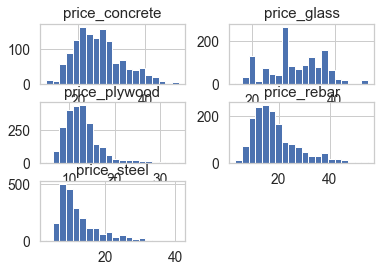

In [12]:
df[price_cols].hist(bins=20)
plt.show()

In [25]:
fig = px.box(df_longer, y='Price', x='Material', color='year')
fig.show()

fig = px.box(df_longer.sort_values('month'), y='Price', x='Material', color='month')
fig.show()

fig = px.box(df_longer.sort_values('dayofweek'), y='Price', x='Material', color='dayofweek')
fig.show()

fig = px.line(df_longer.sort_values('Date'), x='Date', y='Price', line_group='Material', color='Material',
              height=800)
fig.show()

fig = px.line(df_longer.sort_values('Date'), x='Date', y='Price', line_group='Material', color='Material',
              facet_row='year', height=1400)
fig.update_xaxes(matches=None)
fig.show()

Plywood and glass have an upward trend over the years, but the other materials look more stable with cyclic patterns

## Time series decomposition

### Format for time series

In [14]:
df = df.set_index('Date')  # Set the datetimeindex
df = df.resample('B').pad()  # Set sample frequency to every business day
display(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2626 entries, 2008-05-27 to 2018-06-19
Freq: B
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   price_steel     2252 non-null   float64 
 1   price_rebar     1636 non-null   float64 
 2   price_glass     1371 non-null   float64 
 3   price_concrete  1356 non-null   float64 
 4   price_plywood   2501 non-null   float64 
 5   year            2626 non-null   category
 6   month           2626 non-null   category
 7   day             2626 non-null   int64   
 8   dayofyear       2626 non-null   int64   
 9   dayofweek       2626 non-null   category
 10  isweekday       2626 non-null   bool    
 11  week            2626 non-null   category
dtypes: bool(1), category(4), float64(5), int64(2)
memory usage: 181.0 KB


None

### Fill in NA values

I need to do this because the time series functions don't like missing values.
Use forward fill approach because it makes more sense than backward filling here, and using average imputation instead is not recommended for time series.

In [15]:
df_filled = df.copy()
for m in price_cols:
    df_filled[m] = df_filled[m].fillna(method='ffill')
df_filled

price_steel  price_rebar  price_glass  price_concrete  \
Date                                                                
2008-05-27    11.625000        16.50         20.0       38.000000   
2008-05-28    11.625000        17.25         20.0       38.500000   
2008-05-29    11.625000        17.25         20.0       38.500000   
2008-05-30    11.500000        14.25         20.0       29.600000   
2008-06-02    10.833333        16.50         20.0       30.666667   
...                 ...          ...          ...             ...   
2018-06-13     8.750000        23.00         34.0       48.000000   
2018-06-14     8.750000        23.00         34.0       48.000000   
2018-06-15     8.750000        23.00         34.0       48.000000   
2018-06-18     8.750000        23.00         34.0       48.000000   
2018-06-19     8.750000        23.00         34.0       48.000000   

            price_plywood  year month  day  dayofyear dayofweek  isweekday  \
Date                                                                         
2008-05-27          8.125  2008     5   27        148         1       True   
2008-05-28         11.000  2008     5   28        149         2       True   
2008-05-29          8.250  2008     5   29        150         3       True   
2008-05-30          8.000  2008     5   30        151         4       True   
2008-06-02          8.000  2008     6    2        154         0       True   
...                   ...   ...   ...  ...        ...       ...        ...   
2018-06-13         13.500  2018     6   13        164         2       True   
2018-06-14         13.500  2018     6   14        165         3       True   
2018-06-15         13.500  2018     6   15        166         4       True   
2018-06-18         13.500  2018     6   18        169         0       True   
2018-06-19         13.500  2018     6   19        170         1       True   

           week  
Date             
2008-05-27   22  
2008-05-28   22  
2008-05-29   22  
2008-05-30   22  
2008-06-02   23  
...         ...  
2018-06-13   24  
2018-06-14   24  
2018-06-15   24  
2018-06-18   25  
2018-06-19   25  

[2626 rows x 12 columns]

### Time series decomposition

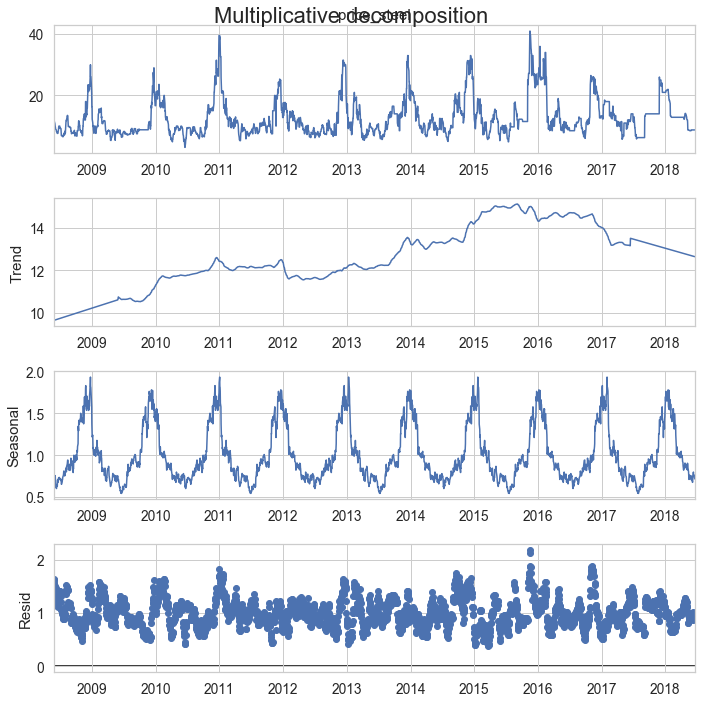

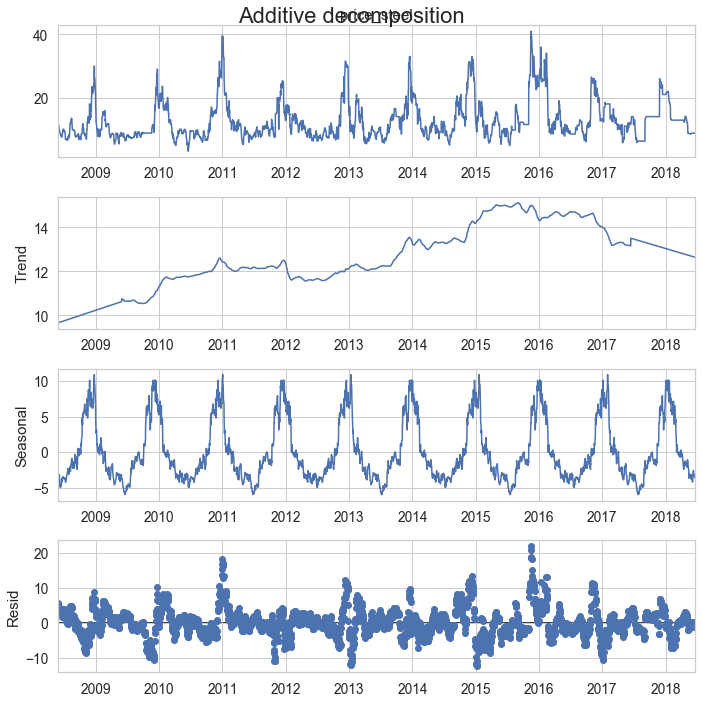

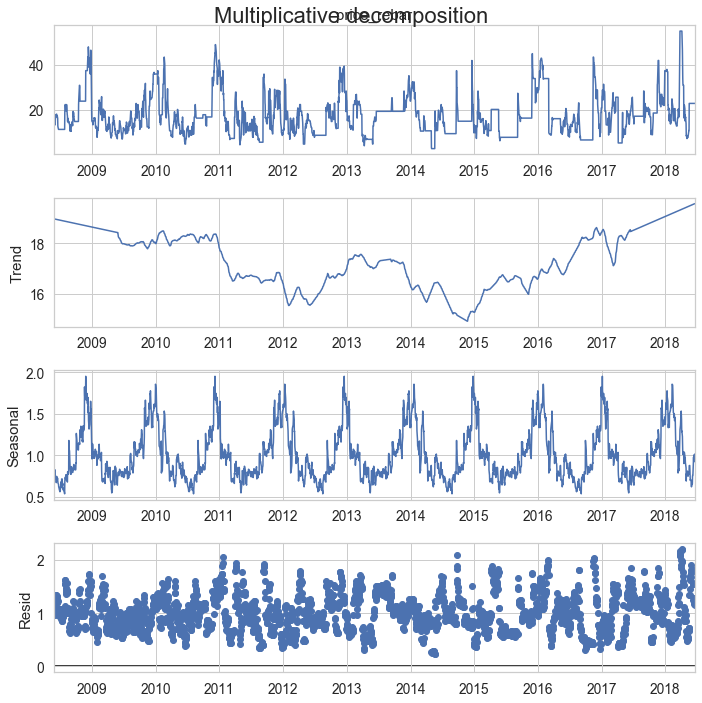

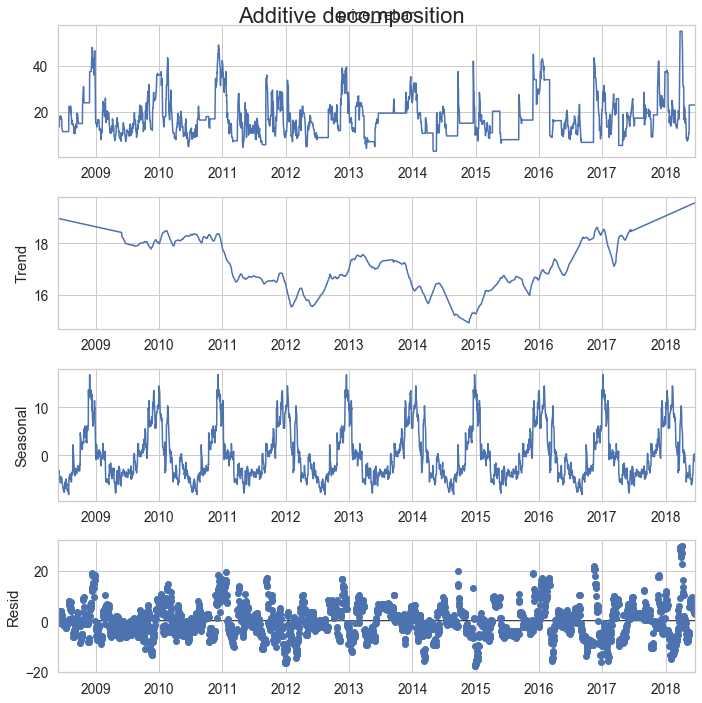

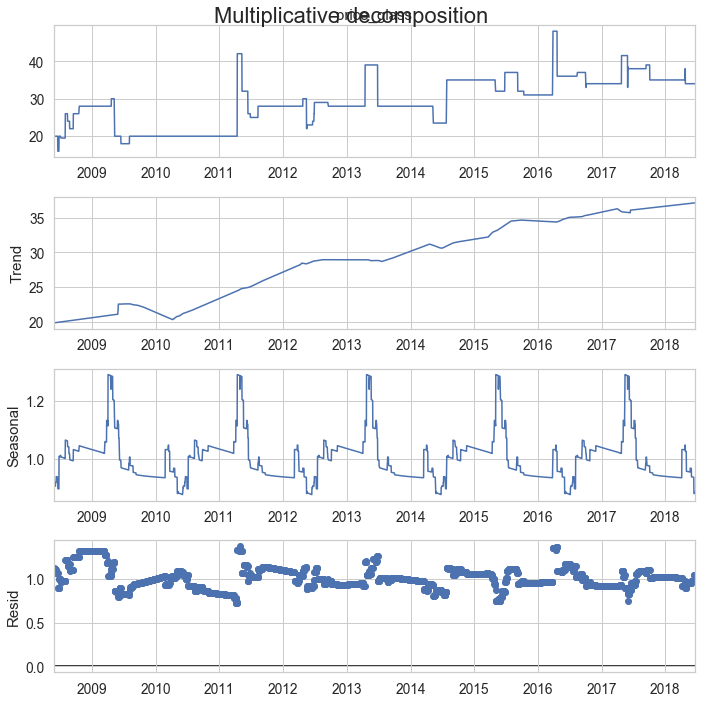

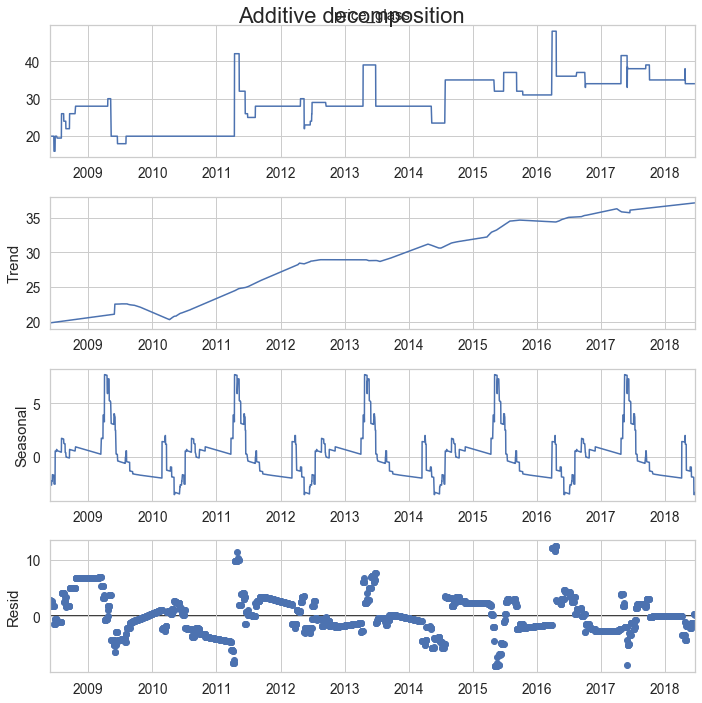

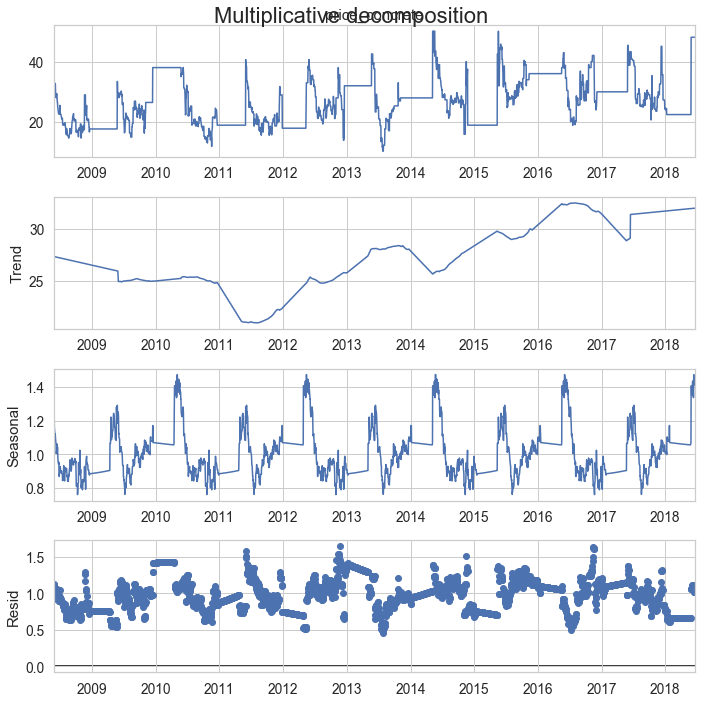

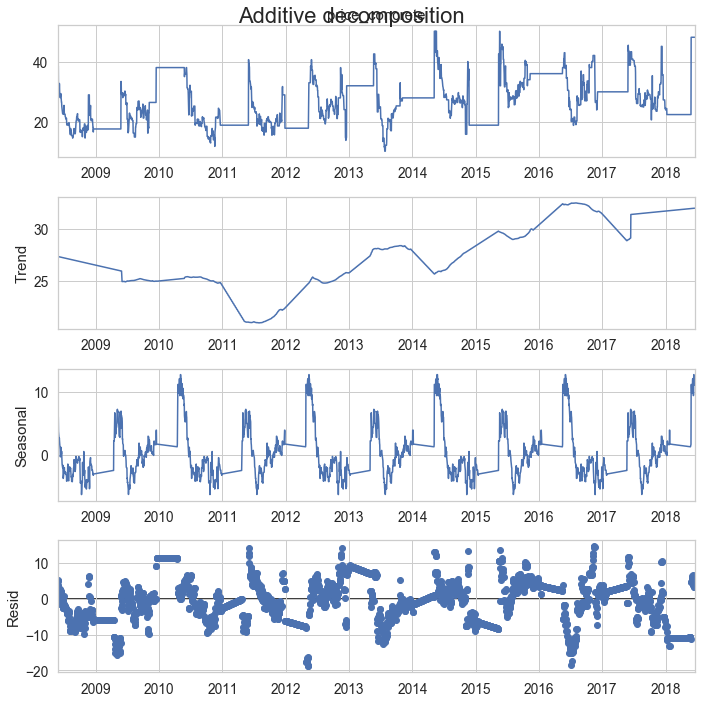

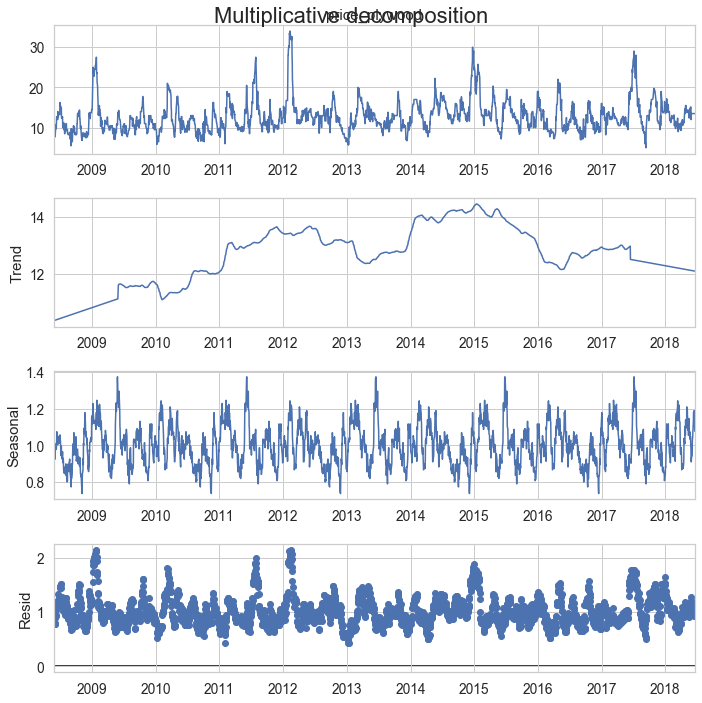

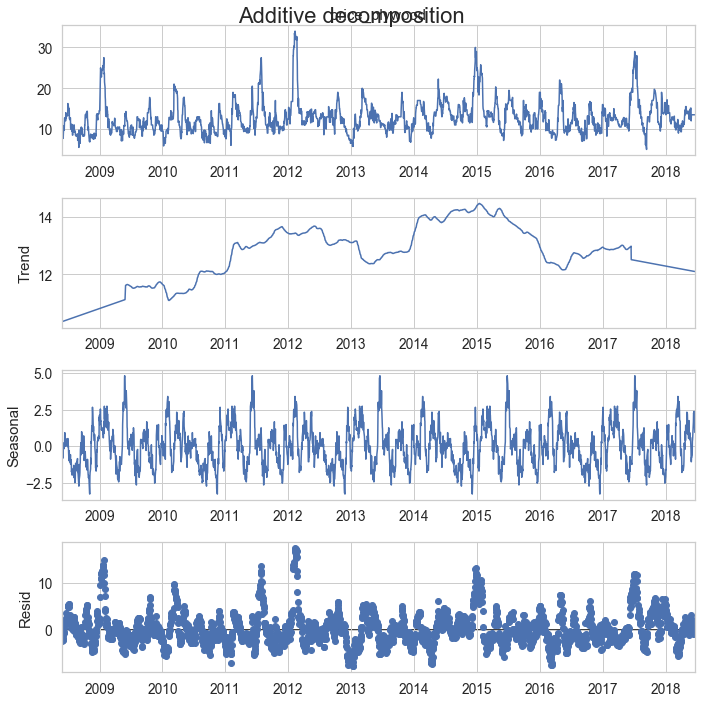

In [16]:
# Find the number of weeks in the dataset and use this as the period for decomposition
decomposition_period = df_filled[['week', 'year']].drop_duplicates().shape[0]

# m = 'price_rebar'
for m in price_cols:
    result_mul = sm.tsa.seasonal_decompose(df_filled[m],
                                           period=decomposition_period,
                                           model='multiplicative',
                                           extrapolate_trend='freq')
    result_add = sm.tsa.seasonal_decompose(df_filled[m],
                                           period=decomposition_period,
                                           model='additive',
                                           extrapolate_trend='freq')
    plt.rcParams.update({'figure.figsize': (10, 10)})
    result_mul.plot().suptitle('Multiplicative decomposition', fontsize=22)
    result_add.plot().suptitle('Additive decomposition', fontsize=22)
    plt.show()

There don't appear to be strong trends, but seasonal/cyclic patterns look interesting.

## Test for stationarity

I'm testing for stationarity here, because if the series are not stationary I'll have to make them stationary before using the ARIMA model for forecasting.

In [17]:
adf_pvals = []
for m in price_cols:
    result = sm.tsa.stattools.adfuller(df_filled[m], autolag='AIC')
    adf_pvals.append(result[1])
    print('-' * 25)
    print(m)
    print(f'\tADF Statistic: {result[0]}')
    print(f'\tp-value: {result[1]}')
    for key, value in result[4].items():
        print('\tCritial Values:')
        print(f'\t\t{key}, {value}')

display([(m, p < 0.05) for m, p in zip(price_cols, adf_pvals)])

-------------------------
price_steel
	ADF Statistic: -6.51328173891808
	p-value: 1.086935504787725e-08
	Critial Values:
		1%, -3.4328608364042927
	Critial Values:
		5%, -2.8626492942003465
	Critial Values:
		10%, -2.567360516871384
-------------------------
price_rebar
	ADF Statistic: -8.313163121628262
	p-value: 3.7413908260892046e-13
	Critial Values:
		1%, -3.432850276300277
	Critial Values:
		5%, -2.8626446306749416
	Critial Values:
		10%, -2.5673580339787834
-------------------------
price_glass
	ADF Statistic: -3.077373340666178
	p-value: 0.028273611394599545
	Critial Values:
		1%, -3.43286180083873
	Critial Values:
		5%, -2.8626497201105283
	Critial Values:
		10%, -2.5673607436289947
-------------------------
price_concrete
	ADF Statistic: -4.831685323967146
	p-value: 4.7282847075739514e-05
	Critial Values:
		1%, -3.4328531475091717
	Critial Values:
		5%, -2.862645898652306
	Critial Values:
		10%, -2.5673587090582717
-------------------------
price_plywood
	ADF Statistic: -8.882

[('price_steel', True),
 ('price_rebar', True),
 ('price_glass', True),
 ('price_concrete', True),
 ('price_plywood', True)]

The null hypothesis of the ADF test is that the time series is non-stationary, so with a significant p value that means it's stationary. All five materials come out as stationary, so there's not much trend to speak of.
This means I can go ahead and use ARIMA without stationarizing the data.

## Forecast using ARIMA

I'll be using univariate forecasting with ARIMA

p: number of lags to use as predictors (order of AR autoregressive term)
d: probably 0 because the prices are already stationary
q: number of lagged forecast errors to include (order of MA moving average term)

### Determine order of AR term (p)

p is the number of lags that cross the significance threshold in the partial autocorrelation plot

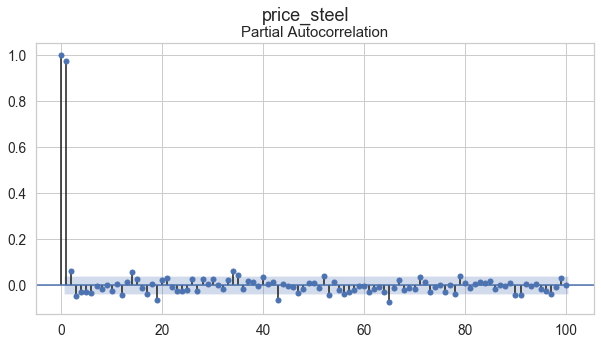

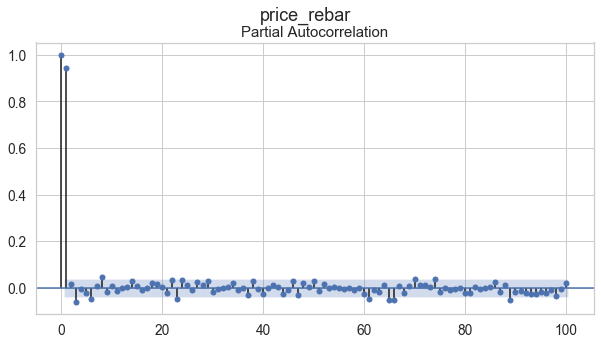

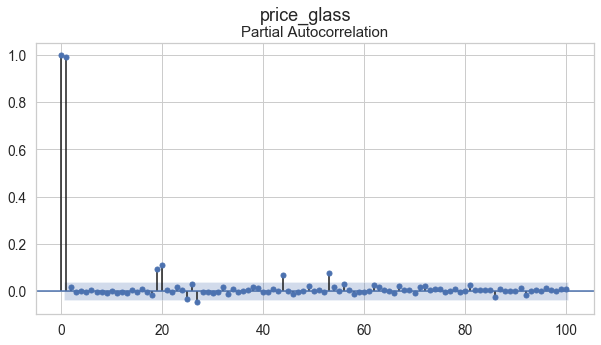

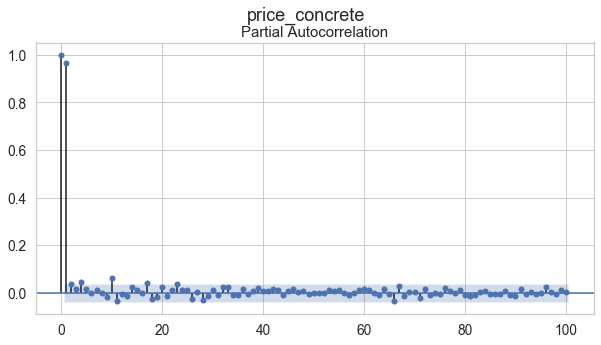

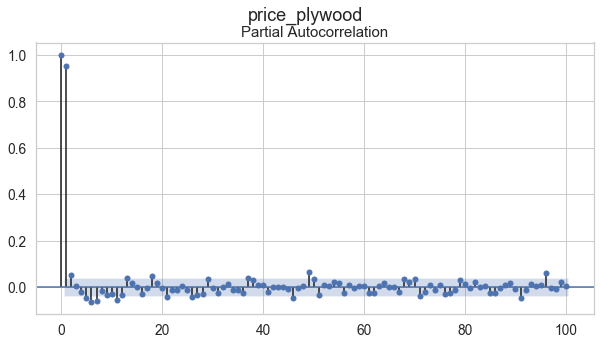

In [18]:
plt.rcParams.update({'figure.figsize': (10, 5)})
for m in price_cols:
    sm.graphics.tsa.plot_pacf(df_filled[m], lags=100).suptitle(m, fontsize=18)
    plt.show()

steel: 1
rebar: 1
glass: 1
concrete: 1
plywood: 1

### Determine order of the MA term (q)

How many MA terms are required to remove autocorrelation?
The number of lags the cross the significance threshold in the autocorrelation plot

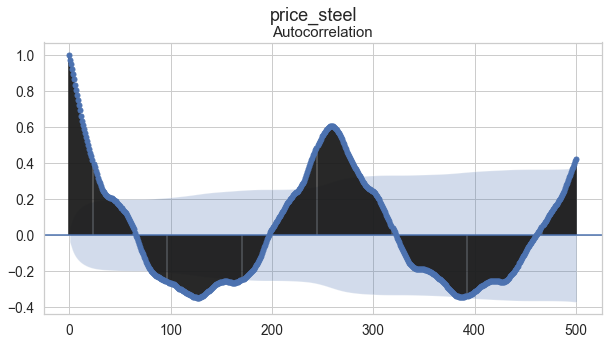

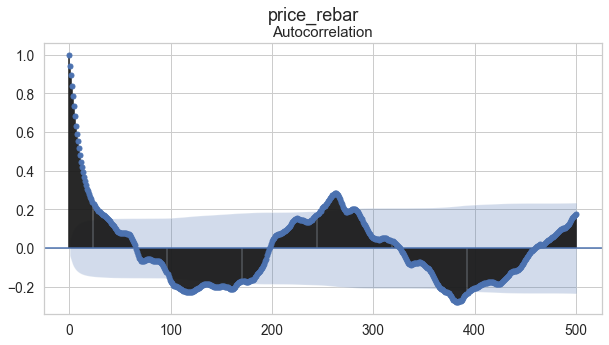

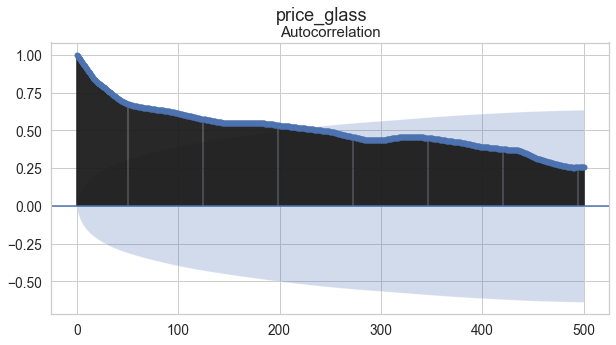

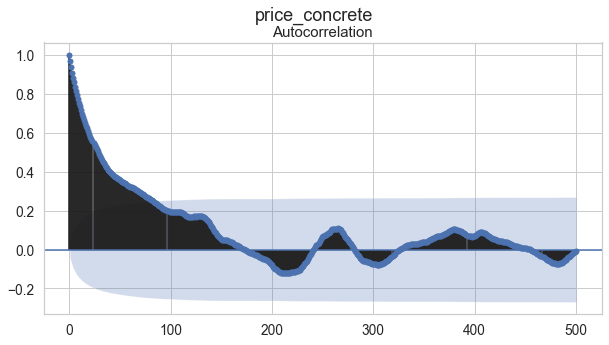

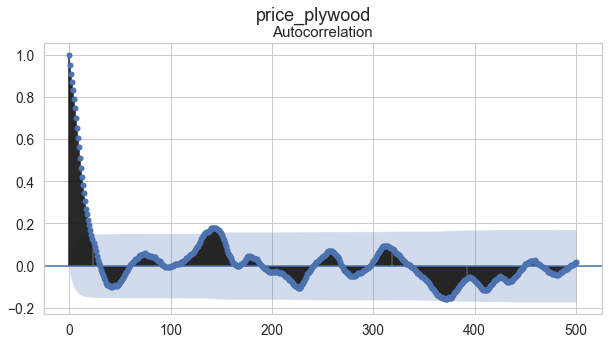

In [19]:
plt.rcParams.update({'figure.figsize': (10, 5)})
for m in price_cols:
    sm.graphics.tsa.plot_acf(df_filled[m], lags=500).suptitle(m, fontsize=18)
    plt.show()

steel: 30 - 43
rebar: 27 - 36
glass: ~200
concrete: 60 - 80
plywood: 21

### Set parameters for ARIMA

In [20]:
arima_params = {
'price_steel': {'p': 1, 'q': 30},
'price_rebar': {'p': 1, 'q': 27},
'price_glass': {'p': 1, 'q': 200},
'price_concrete': {'p': 1, 'q': 60},
'price_plywood': {'p': 1, 'q': 21}
}
display(arima_params)

{'price_steel': {'p': 1, 'q': 30},
 'price_rebar': {'p': 1, 'q': 27},
 'price_glass': {'p': 1, 'q': 200},
 'price_concrete': {'p': 1, 'q': 60},
 'price_plywood': {'p': 1, 'q': 21}}

These numbers are pretty high, and it was actually difficult to fit a model with 200 terms in it. So I went more conservative and set q to 10 for everything. Some of the 10 terms weren't significant anyway in the models I ended up fitting, so this seems reasonable.

### Get training and test sets

Split the data into a training set (the first 80%) and a test set (the last 20%)

In [21]:
train_max_idx = round(df_filled.shape[0] * 0.8) - 1
train = df_filled.iloc[:train_max_idx]
train.shape
test = df_filled.iloc[train_max_idx: ]
test.shape

display(train.index[-1] - train.index[0])
display(test.index[-1] - test.index[0])

Timedelta('2939 days 00:00:00')

Timedelta('735 days 00:00:00')

Trained on 2900 days and tested on 735 days

### Out of time cross validation

Use the out of time test set to evaluate the forecast values from the fit models.

-------------------------
price_steel
                               SARIMAX Results                                
Dep. Variable:            price_steel   No. Observations:                 2100
Model:                ARIMA(1, 0, 10)   Log Likelihood               -3848.091
Date:                Tue, 31 Mar 2020   AIC                           7722.183
Time:                        17:29:34   BIC                           7795.629
Sample:                    05-27-2008   HQIC                          7749.084
                         - 06-13-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5213      1.367      9.161      0.000       9.842      15.200
ar.L1          0.9611      0.007    133.799      0.000       0.947       0.975
ma.L1         

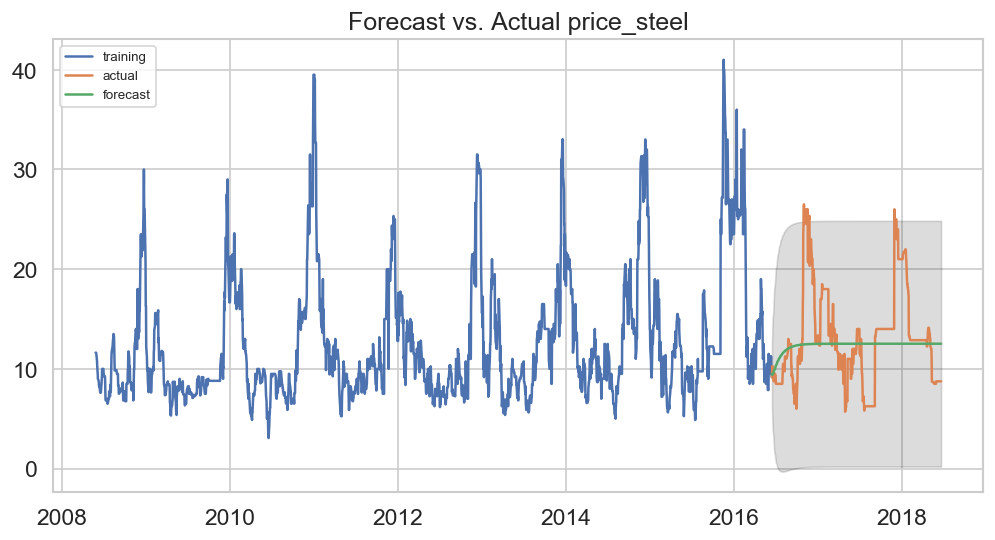

-------------------------
price_rebar
                               SARIMAX Results                                
Dep. Variable:            price_rebar   No. Observations:                 2100
Model:                ARIMA(1, 0, 10)   Log Likelihood               -5055.716
Date:                Tue, 31 Mar 2020   AIC                          10137.431
Time:                        17:29:36   BIC                          10210.877
Sample:                    05-27-2008   HQIC                         10164.333
                         - 06-13-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.1908      1.461     11.766      0.000      14.327      20.054
ar.L1          0.9497      0.011     82.690      0.000       0.927       0.972
ma.L1         

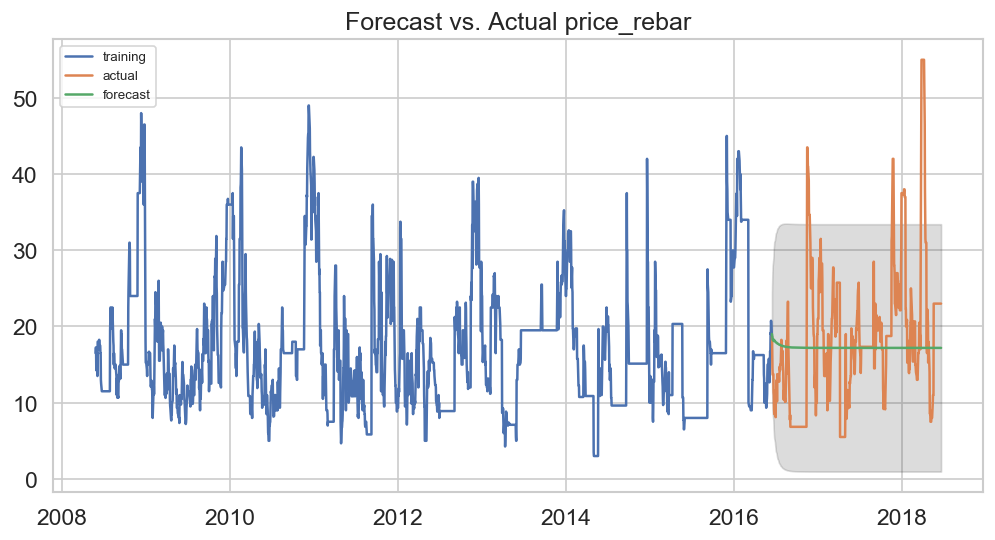

-------------------------
price_glass
                               SARIMAX Results                                
Dep. Variable:            price_glass   No. Observations:                 2100
Model:                ARIMA(1, 0, 10)   Log Likelihood               -2823.151
Date:                Tue, 31 Mar 2020   AIC                           5672.303
Time:                        17:29:39   BIC                           5745.749
Sample:                    05-27-2008   HQIC                          5699.204
                         - 06-13-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.5236      2.169     12.689      0.000      23.272      31.775
ar.L1          0.9868      0.007    133.616      0.000       0.972       1.001
ma.L1         

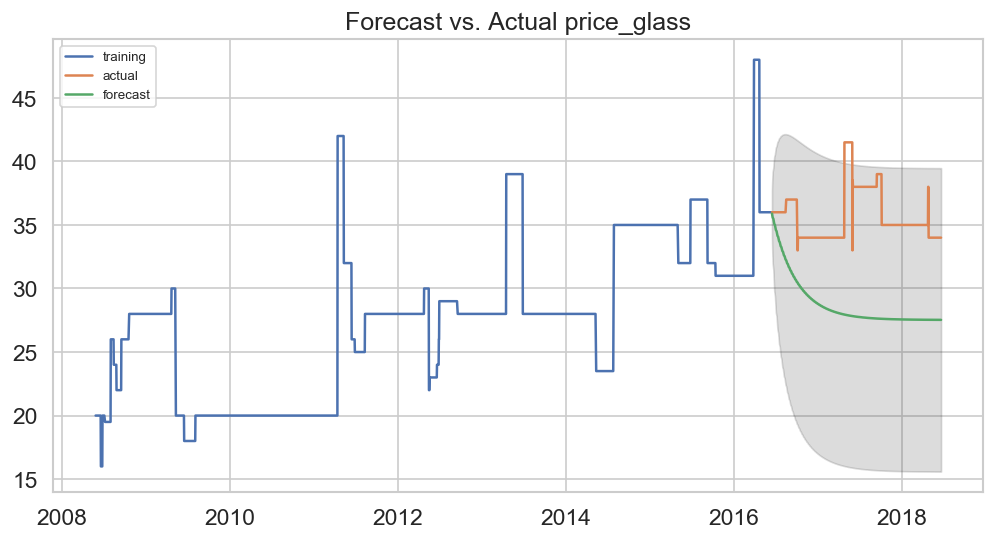

-------------------------
price_concrete
                               SARIMAX Results                                
Dep. Variable:         price_concrete   No. Observations:                 2100
Model:                ARIMA(1, 0, 10)   Log Likelihood               -4211.373
Date:                Tue, 31 Mar 2020   AIC                           8448.745
Time:                        17:29:42   BIC                           8522.191
Sample:                    05-27-2008   HQIC                          8475.646
                         - 06-13-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.3367      2.018     13.051      0.000      22.381      30.292
ar.L1          0.9818      0.006    155.263      0.000       0.969       0.994
ma.L1      

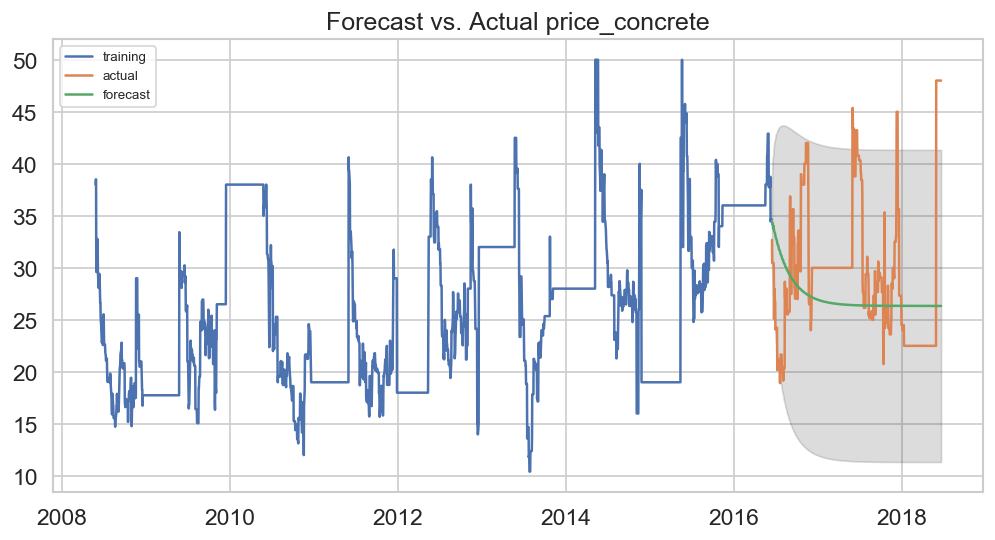

-------------------------
price_plywood
                               SARIMAX Results                                
Dep. Variable:          price_plywood   No. Observations:                 2100
Model:                ARIMA(1, 0, 10)   Log Likelihood               -3321.985
Date:                Tue, 31 Mar 2020   AIC                           6669.970
Time:                        17:29:44   BIC                           6743.416
Sample:                    05-27-2008   HQIC                          6696.872
                         - 06-13-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7711      0.515     24.789      0.000      11.761      13.781
ar.L1          0.9127      0.013     70.074      0.000       0.887       0.938
ma.L1       

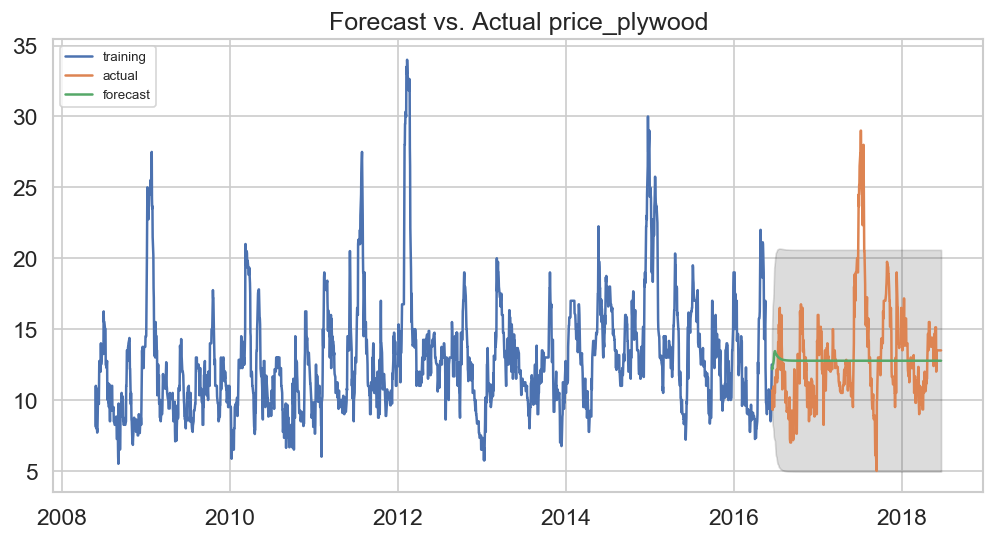

In [28]:
train_model_fits = []
forecasts = []
plt.rcParams.update({'figure.figsize': (10, 5)})
for m in price_cols:
    # m_order = (arima_params[m]['p'], 0, arima_params[m]['q'])
    m_order = (arima_params[m]['p'], 0, 10)
    model = sm.tsa.arima.ARIMA(train[m], order=m_order)
    model_fit = model.fit()
    train_model_fits.append(model_fit)
    print('-' * 25)
    print(m)
    print(model_fit.summary())
    fc = model_fit.get_prediction(start=test.index[0], end=test.index[-1])
    fc_df = fc.summary_frame()
    forecasts.append(fc)
    # plt.figure(figsize(12, 5), dpi=200)
    plt.plot(train[m], label='training')
    plt.plot(test[m], label='actual')
    plt.plot(fc_df['mean'], label='forecast')
    plt.fill_between(fc_df.index, fc_df['mean_ci_lower'], fc_df['mean_ci_upper'],
                     color='k', alpha=0.15)
    plt.title('Forecast vs. Actual {}'.format(m))
    plt.legend(loc='upper left', fontsize=8)
    plt.show()


## Future iterations
- Add seasonality term
- Investigate weekly and monthly aggregated data
- Use grid search and AIC to determine better values for p, d, and q

## Appendix

### Look for seasonality in autocorrelation plots

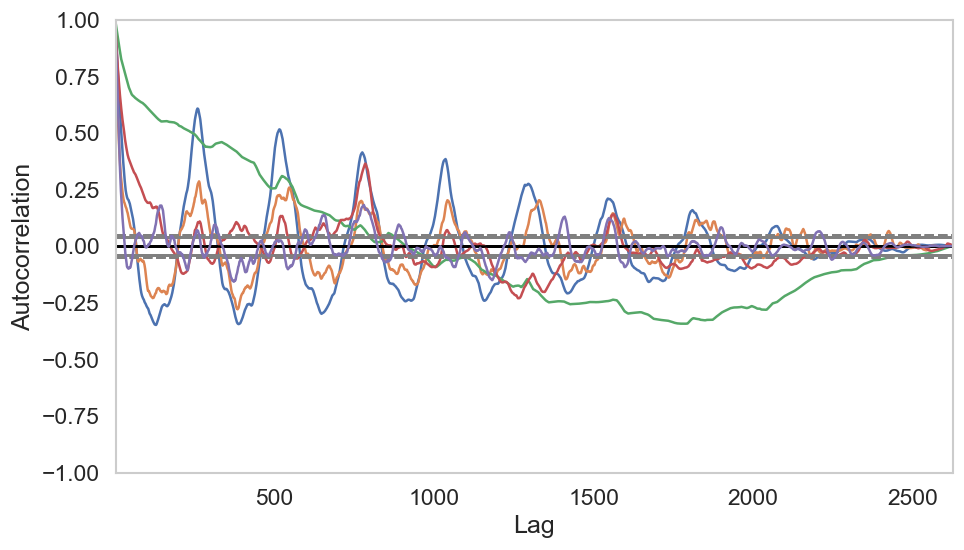

In [23]:
plt.rcParams.update({'figure.figsize': (9, 5), 'figure.dpi': 120})
for m in price_cols:
    ax = pd.plotting.autocorrelation_plot(df_filled[m].tolist())

plt.show()

Not sure how to add labels to this graph, so I'll try the `statmodels` plotting method instead.

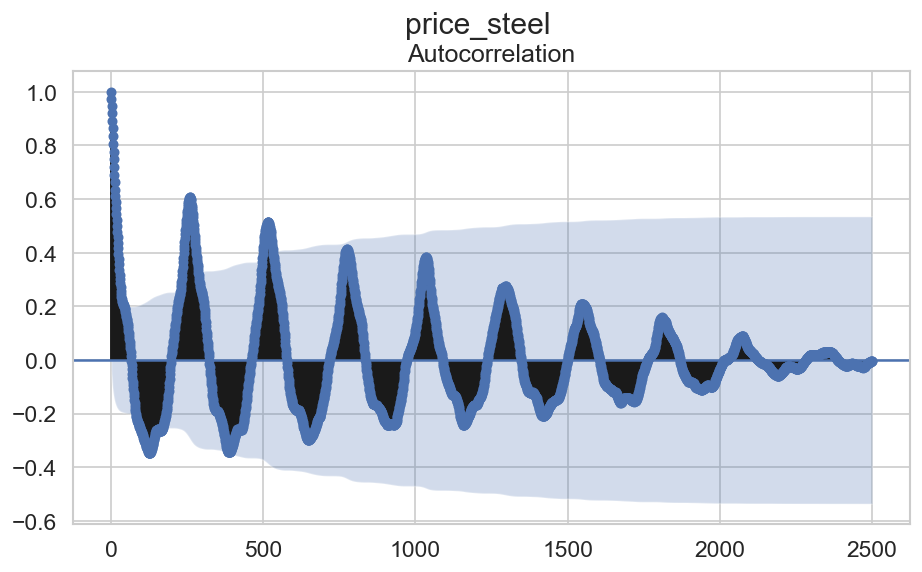

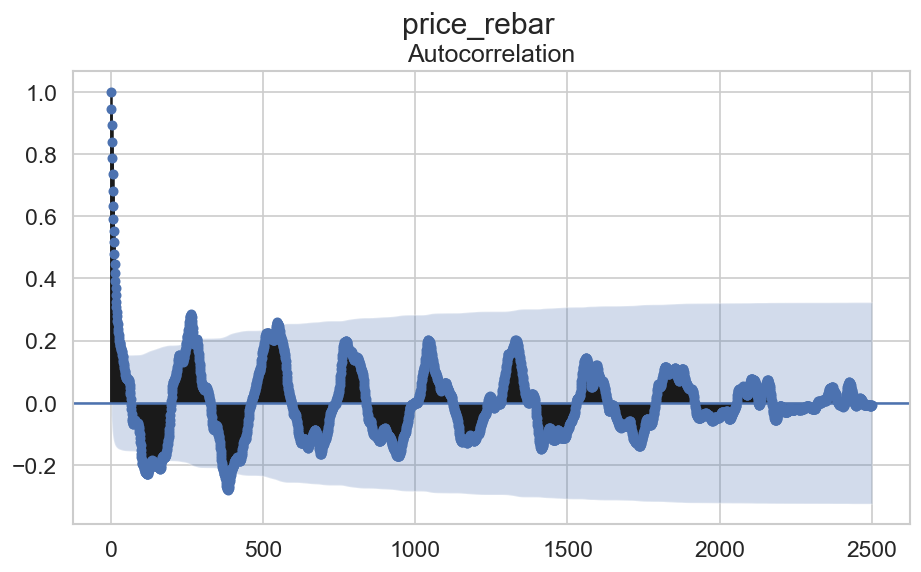

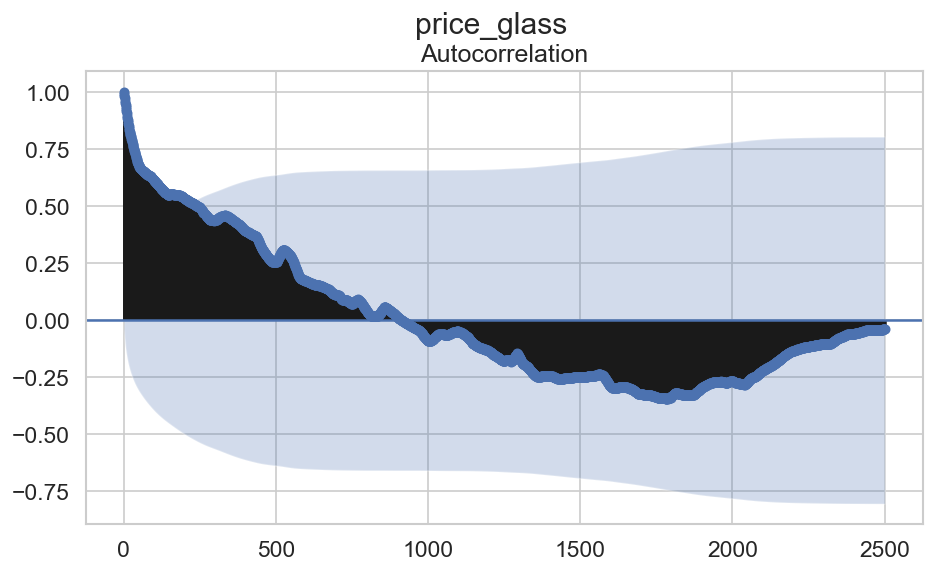

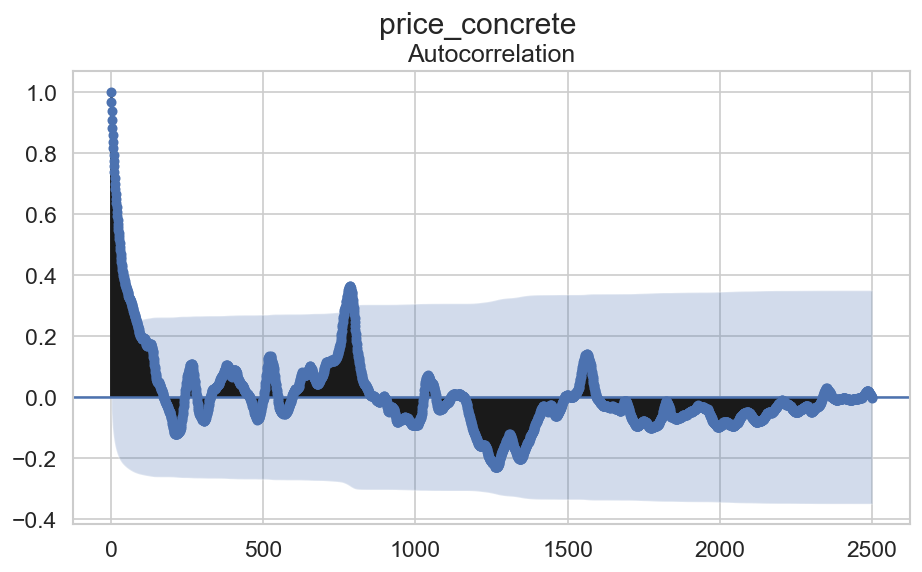

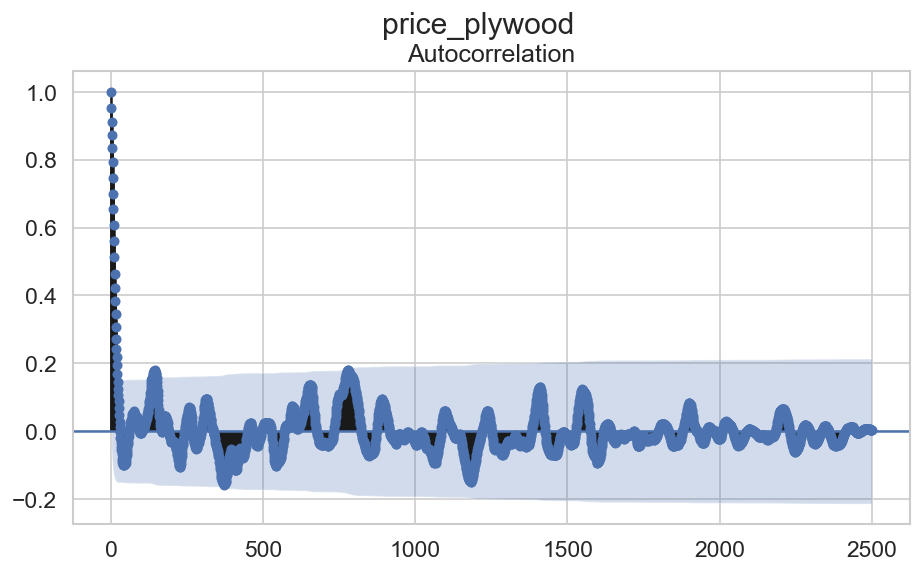

In [24]:
for m in price_cols:
    sm.graphics.tsa.plot_acf(df_filled[m], lags=2500).suptitle(m, fontsize=18)
    plt.show()

There is some strong evidence for seasonality here, so it would be good to go back and use a SARIMA model with a term for seasonality.